# Load packages

In [1]:
import pandas as pd
import numpy as np

In [2]:
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import math
from collections import Counter
import re
import json
from bs4 import BeautifulSoup
import datetime
from pprint import pprint
import requests

In [4]:
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16

Using TensorFlow backend.


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

# Browse images and test resizing 

In [27]:
imgs = glob.glob('MsCelebV1-Faces-Aligned.Samples/MsCelebV1-Faces-Aligned.Samples/**/*.jpg')

In [15]:
len(imgs)

1375

In [16]:
imgs[0]

'MsCelebV1-Faces-Aligned.Samples/MsCelebV1-Faces-Aligned.Samples/m.09yrh/82-FaceId-0.jpg'

In [269]:
img = cv2.imread(imgs[0])

In [270]:
img.shape

(300, 256, 3)

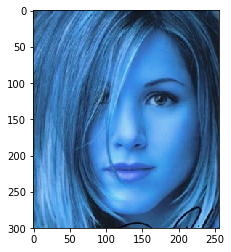

In [271]:
plt.imshow(img)

In [20]:
image = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)

In [21]:
image.shape

(28, 28, 3)

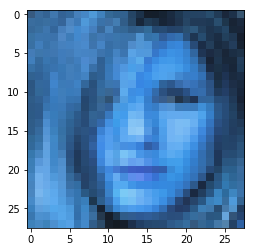

In [22]:
plt.imshow(image)

# Resize all celebrity_align images  to 32 x 32

In [29]:
all_imgs = []
for i in range(0, len(imgs)):
    temp_img = cv2.imread(imgs[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    all_imgs.append(temp_img_resize)

# Load Cifar-10 dataset

In [24]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 1st trial: 
* Combine facial + non-facial datasets (60000 CIFAR10 + 1375 celebrity_align); 
* Split into train and test datasets

### Combine non-facial and facial images

In [27]:
X = np.concatenate((x_train, x_test, all_imgs), axis=0)

In [28]:
len(X)

61375

### Create labels

In [29]:
label_no = list('0') * 60000
label_no = [int(i) for i in label_no]
label_no = np.asarray(label_no)

In [30]:
len(label_no)

60000

In [31]:
label_yes = list('1') * 1375
label_yes = [int(i) for i in label_yes]
label_yes = np.asarray(label_yes)

In [32]:
len(label_yes)

1375

In [33]:
y = np.concatenate((label_no, label_yes), axis=0)

In [34]:
len(y)

61375

In [35]:
from sklearn.model_selection import train_test_split

X_merge_train, X_merge_test, y_merge_train, y_merge_test = train_test_split(X, y, test_size = 0.33, stratify=y)

In [36]:
# Normalize data set to 0-to-1 range
X_merge_train = X_merge_train.astype('float32')
X_merge_test = X_merge_test.astype('float32')
X_merge_train /= 255
X_merge_test /= 255

In [37]:
y_merge_train = keras.utils.to_categorical(y_merge_train, 2)
y_merge_test = keras.utils.to_categorical(y_merge_test, 2)

### Layers for the model

In [336]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [337]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [338]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
__________

In [37]:
model.fit(
    X_merge_train,
    y_merge_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_merge_test, y_merge_test),
    shuffle=True
)

Train on 41121 samples, validate on 20254 samples
Epoch 1/30
41121/41121 [==============================] - 230s 6ms/step - loss: 0.0304 - acc: 0.9909 - val_loss: 0.0138 - val_acc: 0.9967
Epoch 2/30
41121/41121 [==============================] - 244s 6ms/step - loss: 0.0125 - acc: 0.9968 - val_loss: 0.0087 - val_acc: 0.9984
Epoch 3/30
41121/41121 [==============================] - 233s 6ms/step - loss: 0.0106 - acc: 0.9974 - val_loss: 0.0084 - val_acc: 0.9980
Epoch 4/30
41121/41121 [==============================] - 226s 6ms/step - loss: 0.0075 - acc: 0.9981 - val_loss: 0.0077 - val_acc: 0.9983
Epoch 5/30
41121/41121 [==============================] - 239s 6ms/step - loss: 0.0077 - acc: 0.9978 - val_loss: 0.0090 - val_acc: 0.9982
Epoch 6/30
41121/41121 [==============================] - 239s 6ms/step - loss: 0.0071 - acc: 0.9981 - val_loss: 0.0075 - val_acc: 0.9984
Epoch 7/30
41121/41121 [==============================] - 216s 5ms/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0110 - 

In [39]:
# save model structure
from pathlib import Path
model_structure = model.to_json()
f = Path('model_structure.json')
f.write_text(model_structure)

4334

In [41]:
# save model weights
model.save_weights('model_weights.h5')

# 2nd trial: 
* 1375 CIFAR10 + 1375 celebrity_align

In [330]:
X_slice = np.concatenate((x_train[0:1375], all_imgs), axis=0)
len(X_slice)

2750

### Create labels

In [331]:
label_slice_no = list('0') * 1375
label_slice_no = [int(i) for i in label_slice_no]
label_slice_no = np.asarray(label_slice_no)
y_slice = np.concatenate((label_slice_no, label_yes), axis=0)
len(y_slice)

2750

In [332]:
from sklearn.model_selection import train_test_split

X_slice_train, X_slice_test, y_slice_train, y_slice_test = train_test_split(X_slice, y_slice, 
                                                                            test_size = 0.33, stratify=y_slice)

In [333]:
# Normalize data set to 0-to-1 range
X_slice_train = X_slice_train.astype('float32')
X_slice_test = X_slice_test.astype('float32')
X_slice_train /= 255
X_slice_test /= 255

In [334]:
y_slice_train = keras.utils.to_categorical(y_slice_train, 2)
y_slice_test = keras.utils.to_categorical(y_slice_test, 2)

In [339]:
model.fit(
    X_slice_train,
    y_slice_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_slice_test, y_slice_test),
    shuffle=True
)

Train on 1842 samples, validate on 908 samples
Epoch 1/30
1842/1842 [==============================] - 10s 6ms/step - loss: 0.3183 - acc: 0.8610 - val_loss: 0.2175 - val_acc: 0.9108
Epoch 2/30
1842/1842 [==============================] - 9s 5ms/step - loss: 0.1489 - acc: 0.9495 - val_loss: 0.0585 - val_acc: 0.9835
Epoch 3/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0813 - acc: 0.9707 - val_loss: 0.0489 - val_acc: 0.9846
Epoch 4/30
1842/1842 [==============================] - 9s 5ms/step - loss: 0.0551 - acc: 0.9794 - val_loss: 0.0452 - val_acc: 0.9857
Epoch 5/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0597 - acc: 0.9729 - val_loss: 0.0355 - val_acc: 0.9835
Epoch 6/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0378 - acc: 0.9821 - val_loss: 0.0286 - val_acc: 0.9901
Epoch 7/30
 608/1842 [========>.....................] - ETA: 6s - loss: 0.0235 - acc: 0.9951

KeyboardInterrupt: 

### Load model

In [242]:
from pathlib import Path
f = Path('model_structure_slice.json')
model_structure = f.read_text()

In [243]:
from keras.models import model_from_json
model = model_from_json(model_structure)

In [244]:
model.load_weights("model_weights_slice.h5")

### Randomly pick 20 samples from X_slice_test 1000 times
### Calculate each time's score and plot in the histogram

In [249]:
idx_1000 = [np.random.randint(len(X_slice_test), size=20) for i in range(1000)]    

In [250]:
from sklearn.metrics import accuracy_score

score = []
for i in idx_1000:
    test = X_slice_test[i]
    observe = y_slice_test[i]
    result = model.predict(test)
    rounded_result = np.rint(result)
    score.append(accuracy_score(rounded_result, observe))

(array([  3.,   0.,   0.,   0.,   0.,  81.,   0.,   0.,   0., 916.]),
 array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <a list of 10 Patch objects>)

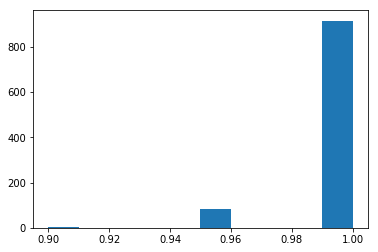

In [251]:
plt.hist(score)

# 3rd model: grayscale
* same setting as 2nd trial
* X_slice -> gray scale
* y_slice -> same

In [285]:
# convert BGR images into gray scale
X_slice_gray =  [ cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in X_slice ]

In [353]:
X_slice_gray = np.array(X_slice_gray)

In [388]:
# add one more dimension
X_slice_gray_dim = [np.expand_dims(i, axis=2) for i in X_slice_gray]

In [394]:
X_slice_gray_dim = np.array(X_slice_gray_dim)

In [395]:
from sklearn.model_selection import train_test_split

X_slice_gray_train, X_slice_gray_test, y_slice_train, y_slice_test = train_test_split(X_slice_gray_dim, y_slice, 
                                                                                      test_size = 0.33, stratify=y_slice)
                                                            

In [397]:
# Normalize data set to 0-to-1 range
X_slice_gray_train = X_slice_gray_train.astype('float32')
X_slice_gray_test = X_slice_gray_test.astype('float32')
X_slice_gray_train /= 255
X_slice_gray_test /= 255


In [398]:
y_slice_train = keras.utils.to_categorical(y_slice_train, 2)
y_slice_test = keras.utils.to_categorical(y_slice_test, 2)


In [399]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1), activation="relu"))
model3.add(Conv2D(32, (3, 3), activation="relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model3.add(Conv2D(64, (3, 3), activation="relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation="softmax"))

In [400]:
model3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [401]:
model3.fit(
    X_slice_gray_train,
    y_slice_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_slice_gray_test, y_slice_test),
    shuffle=True
)

Train on 1842 samples, validate on 908 samples
Epoch 1/30
1842/1842 [==============================] - 10s 6ms/step - loss: 0.3851 - acc: 0.7904 - val_loss: 0.1487 - val_acc: 0.9350
Epoch 2/30
1842/1842 [==============================] - 9s 5ms/step - loss: 0.1172 - acc: 0.9577 - val_loss: 0.0870 - val_acc: 0.9681
Epoch 3/30
1842/1842 [==============================] - 9s 5ms/step - loss: 0.0724 - acc: 0.9734 - val_loss: 0.0865 - val_acc: 0.9637
Epoch 4/30
1842/1842 [==============================] - 9s 5ms/step - loss: 0.0629 - acc: 0.9788 - val_loss: 0.0695 - val_acc: 0.9769
Epoch 5/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0449 - acc: 0.9826 - val_loss: 0.0977 - val_acc: 0.9670
Epoch 6/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0426 - acc: 0.9832 - val_loss: 0.0739 - val_acc: 0.9802
Epoch 7/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0370 - acc: 0.9881 - val_loss: 0.0652 - val_acc: 0.9791
Epoch 8/30


### Save model3

In [407]:
# save model structure
from pathlib import Path
model3_structure = model3.to_json()

f = Path('model3_structure.json')
f.write_text(model3_structure)

4345

In [410]:
# save model weights
model3.save_weights('model3_weights.h5')

# 4th model
* 1375 landscape + 1375 facial images (total 2750)

### load ladnscape images, randomly collect 1375 images, read in by cv2 and convert to 32x32

In [253]:
landscape = glob.glob('val_256/*.jpg')


In [298]:
# get 1375 index randomly from the length of landscape 
index_1375 = np.random.randint(len(landscape), size=1375)

In [301]:
landscape_1375 = []
for i in index_1375:
    temp_img = cv2.imread(landscape[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    landscape_1375.append(temp_img_resize)

### merge with 1375 celebrity_align images

In [304]:
X_land = np.concatenate((landscape_1375, all_imgs), axis=0)
len(X_land)

2750

In [402]:
from sklearn.model_selection import train_test_split
X_land_train, X_land_test, y_land_train, y_land_test = train_test_split(X_land, y_slice, 
                                                                            test_size = 0.33, stratify=y_slice)


In [403]:
# Normalize data set to 0-to-1 range
X_land_train = X_land_train.astype('float32')
X_land_test = X_land_test.astype('float32')
X_land_train /= 255
X_land_test /= 255

In [404]:
y_land_train = keras.utils.to_categorical(y_land_train, 2)
y_land_test = keras.utils.to_categorical(y_land_test, 2)

In [405]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model4.add(Conv2D(32, (3, 3), activation="relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model4.add(Conv2D(64, (3, 3), activation="relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512, activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(2, activation="softmax"))

model4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [406]:
model4.fit(
    X_land_train,
    y_land_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_land_test, y_land_test),
    shuffle=True
)

Train on 1842 samples, validate on 908 samples
Epoch 1/30
1842/1842 [==============================] - 11s 6ms/step - loss: 0.4172 - acc: 0.7894 - val_loss: 0.1659 - val_acc: 0.9460
Epoch 2/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.1421 - acc: 0.9446 - val_loss: 0.0896 - val_acc: 0.9637
Epoch 3/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0995 - acc: 0.9631 - val_loss: 0.0886 - val_acc: 0.9626
Epoch 4/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0685 - acc: 0.9772 - val_loss: 0.0690 - val_acc: 0.9747
Epoch 5/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0593 - acc: 0.9794 - val_loss: 0.0622 - val_acc: 0.9791
Epoch 6/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0621 - acc: 0.9772 - val_loss: 0.0736 - val_acc: 0.9747
Epoch 7/30
1842/1842 [==============================] - 10s 5ms/step - loss: 0.0502 - acc: 0.9788 - val_loss: 0.0631 - val_acc: 0.9813
Epoch 8/

### Save model4

In [409]:
# save model structure
from pathlib import Path
model4_structure = model4.to_json()

f = Path('model4_structure.json')
f.write_text(model4_structure)

4345

In [411]:
# save model weights
model4.save_weights('model4_weights.h5')

# Model5 
* 4256 landscape + 4256 celebrity_align and celebrity_crop (8512 images)

### load two celebrity_cropped and celebrity_thumbnail images, read in by cv2 and resize to 32x32, merge with celebrity_align (total is 4256 facial images)

In [24]:
imgs1 = glob.glob('MsCelebV1-Faces-Cropped.Samples/MsCelebV1-Faces-Cropped.Samples/**/*.jpg')
imgs2 = glob.glob('MsCelebV1-ImageThumbnails.Samples/MsCelebV1-ImageThumbnails.Samples/**/*.jpg')

In [25]:
all_imgs1 = []
for i in range(0, len(imgs1)):
    temp_img = cv2.imread(imgs1[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    all_imgs1.append(temp_img_resize)

In [26]:
all_imgs2 = []
for i in range(0, len(imgs2)):
    temp_img = cv2.imread(imgs2[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    all_imgs2.append(temp_img_resize)

In [30]:
facial_image = np.concatenate((all_imgs, all_imgs1, all_imgs2), axis=0)

In [31]:
len(facial_image)

4256

### load ladnscape images, randomly collect 4256 images, read in by cv2 and convert to 32x32

In [32]:
# get 4256 index randomly from the length of landscape 
index_4256 = np.random.randint(len(landscape), size=4256)

# use index to select files
landscape_4256 = []
for i in index_4256:
    temp_img = cv2.imread(landscape[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    landscape_4256.append(temp_img_resize)

### save those randomly picked indexes (4256)

In [74]:
import pickle

with open("index_4256.txt", "wb") as fp:   #Pickling
    pickle.dump(index_4256, fp)

#with open("test.txt", "rb") as fp:   # Unpickling
    #b = pickle.load(fp)

### merge facial and landscape images

In [34]:
facial_land_image = np.concatenate((landscape_4256, facial_image), axis=0)

In [35]:
len(facial_land_image)

8512

### label

In [36]:
label_full_no = list('0') * 4256
label_full_no = [int(i) for i in label_full_no]
label_full_no = np.asarray(label_full_no)

label_full_yes = list('1') * 4256
label_full_yes = [int(i) for i in label_full_yes]
label_full_yes = np.asarray(label_full_yes)

label_full = np.concatenate((label_full_no, label_full_yes), axis=0)

In [37]:
from sklearn.model_selection import train_test_split
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(facial_land_image, label_full, 
                                                                            test_size = 0.33, stratify=label_full)

# Normalize data set to 0-to-1 range
X_full_train = X_full_train.astype('float32')
X_full_test = X_full_test.astype('float32')
X_full_train /= 255
X_full_test /= 255

# categorize target variable
y_full_train = keras.utils.to_categorical(y_full_train, 2)
y_full_test = keras.utils.to_categorical(y_full_test, 2)

In [38]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model5.add(Conv2D(32, (3, 3), activation="relu"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model5.add(Conv2D(64, (3, 3), activation="relu"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(512, activation="relu"))
model5.add(Dropout(0.5))
model5.add(Dense(2, activation="softmax"))

model5.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [39]:
model5.fit(
    X_full_train,
    y_full_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_full_test, y_full_test),
    shuffle=True
)

Train on 5703 samples, validate on 2809 samples
Epoch 1/30
5703/5703 [==============================] - 33s 6ms/step - loss: 0.4079 - acc: 0.8120 - val_loss: 0.2585 - val_acc: 0.8960
Epoch 2/30
5703/5703 [==============================] - 33s 6ms/step - loss: 0.2603 - acc: 0.8962 - val_loss: 0.2114 - val_acc: 0.9092
Epoch 3/30
5703/5703 [==============================] - 31s 5ms/step - loss: 0.2157 - acc: 0.9158 - val_loss: 0.2021 - val_acc: 0.9181
Epoch 4/30
5703/5703 [==============================] - 31s 5ms/step - loss: 0.1787 - acc: 0.9304 - val_loss: 0.1841 - val_acc: 0.9231
Epoch 5/30
5703/5703 [==============================] - 31s 5ms/step - loss: 0.1716 - acc: 0.9385 - val_loss: 0.1815 - val_acc: 0.9242
Epoch 6/30
5703/5703 [==============================] - 31s 5ms/step - loss: 0.1574 - acc: 0.9397 - val_loss: 0.1821 - val_acc: 0.9288
Epoch 7/30
5703/5703 [==============================] - 29s 5ms/step - loss: 0.1384 - acc: 0.9484 - val_loss: 0.1895 - val_acc: 0.9292
Epoch 8

In [448]:
# save model structure
from pathlib import Path
model5_structure = model5.to_json()

f = Path('model5_structure.json')
f.write_text(model5_structure)

# save model weights
model5.save_weights('model5_weights.h5')

# Model 6 
* 13233 landscape + 13233lfw (total 26466 images)

### load all lFW images, read in by cv2 and resize to 32x32

In [6]:
imgs4 = glob.glob('lFW/**/*.jpg')

In [8]:
all_imgs4 = []
for i in range(0, len(imgs4)):
    temp_img = cv2.imread(imgs4[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    all_imgs4.append(temp_img_resize)

In [9]:
len(all_imgs4)

13233

In [20]:
all_imgs4[0].shape

(32, 32, 3)

### load ladnscape images, randomly collect 13233 images, read in by cv2 and convert to 32x32

In [10]:
landscape = glob.glob('val_256/*.jpg')

In [11]:
# get 13233 index randomly from the length of landscape 
index_13233 = np.random.randint(len(landscape), size=13233)

# use index to select files
landscape_13233 = []
for i in index_13233:
    temp_img = cv2.imread(landscape[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    landscape_13233.append(temp_img_resize)

In [12]:
len(landscape_13233)

13233

### merge facial and landscape images

In [13]:
full = np.concatenate((landscape_13233, all_imgs4), axis=0)
len(full)

26466

### label

In [14]:
label_full_no = list('0') * 13233
label_full_no = [int(i) for i in label_full_no]
label_full_no = np.asarray(label_full_no)

label_full_yes = list('1') * 13233
label_full_yes = [int(i) for i in label_full_yes]
label_full_yes = np.asarray(label_full_yes)

label_full = np.concatenate((label_full_no, label_full_yes), axis=0)

In [15]:
len(label_full)

26466

In [16]:
from sklearn.model_selection import train_test_split
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(full, label_full, 
                                                                            test_size = 0.33, stratify=label_full)

# Normalize data set to 0-to-1 range
X_full_train = X_full_train.astype('float32')
X_full_test = X_full_test.astype('float32')
X_full_train /= 255
X_full_test /= 255

# categorize target variable
y_full_train = keras.utils.to_categorical(y_full_train, 2)
y_full_test = keras.utils.to_categorical(y_full_test, 2)

In [17]:
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model6.add(Conv2D(32, (3, 3), activation="relu"))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.25))

model6.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model6.add(Conv2D(64, (3, 3), activation="relu"))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.25))

model6.add(Flatten())
model6.add(Dense(512, activation="relu"))
model6.add(Dropout(0.5))
model6.add(Dense(2, activation="softmax"))

model6.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [21]:
model6.fit(
    X_full_train,
    y_full_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_full_test, y_full_test),
    shuffle=True
)

Train on 17732 samples, validate on 8734 samples
Epoch 1/30
17732/17732 [==============================] - 94s 5ms/step - loss: 0.1014 - acc: 0.9592 - val_loss: 0.0334 - val_acc: 0.9891
Epoch 2/30
17732/17732 [==============================] - 90s 5ms/step - loss: 0.0247 - acc: 0.9913 - val_loss: 0.0208 - val_acc: 0.9928
Epoch 3/30
17732/17732 [==============================] - 93s 5ms/step - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0188 - val_acc: 0.9945
Epoch 4/30
17732/17732 [==============================] - 89s 5ms/step - loss: 0.0207 - acc: 0.9931 - val_loss: 0.0154 - val_acc: 0.9948
Epoch 5/30
17732/17732 [==============================] - 96s 5ms/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0295 - val_acc: 0.9894
Epoch 6/30
17732/17732 [==============================] - 89s 5ms/step - loss: 0.0139 - acc: 0.9949 - val_loss: 0.0099 - val_acc: 0.9963
Epoch 7/30
17732/17732 [==============================] - 93s 5ms/step - loss: 0.0131 - acc: 0.9955 - val_loss: 0.0135 - val_acc:

In [23]:
# save model structure
from pathlib import Path
model6_structure = model6.to_json()

f = Path('model6_structure.json')
f.write_text(model6_structure)

# save model weights
model6.save_weights('model6_weights.h5')

# Model 7
* 5000 landscape + 5000 lfw (total 10000 images)

### randomly collect 5000 images, read in by cv2 and convert to 32x32


In [50]:
# get 5000 index randomly from the length of all_imgs4
index_5000 = np.random.randint(len(all_imgs4), size=5000)

lfw_5000 = [all_imgs4[i] for i in index_5000]

In [51]:
len(lfw_5000)

5000

### randomly collect 5000 images, read in by cv2 and convert to 32x32

In [48]:
# get 5000 index randomly from the length of landscape 
index_5000 = np.random.randint(len(landscape), size=5000)

# use index to select files
landscape_5000 = []
for i in index_5000:
    temp_img = cv2.imread(landscape[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    landscape_5000.append(temp_img_resize)

In [49]:
len(landscape_5000)

5000

### merge facial and landscape images

In [52]:
full_5000 = np.concatenate((landscape_5000, lfw_5000), axis=0)

In [53]:
label_full_no = list('0') * 5000
label_full_no = [int(i) for i in label_full_no]
label_full_no = np.asarray(label_full_no)

label_full_yes = list('1') * 5000
label_full_yes = [int(i) for i in label_full_yes]
label_full_yes = np.asarray(label_full_yes)

label_full = np.concatenate((label_full_no, label_full_yes), axis=0)

In [54]:
len(label_full)

10000

In [55]:
from sklearn.model_selection import train_test_split
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(full_5000, label_full, 
                                                                            test_size = 0.33, stratify=label_full)

# Normalize data set to 0-to-1 range
X_full_train = X_full_train.astype('float32')
X_full_test = X_full_test.astype('float32')
X_full_train /= 255
X_full_test /= 255

# categorize target variable
y_full_train = keras.utils.to_categorical(y_full_train, 2)
y_full_test = keras.utils.to_categorical(y_full_test, 2)

In [56]:
model7 = Sequential()
model7.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model7.add(Conv2D(32, (3, 3), activation="relu"))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.25))

model7.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model7.add(Conv2D(64, (3, 3), activation="relu"))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.25))

model7.add(Flatten())
model7.add(Dense(512, activation="relu"))
model7.add(Dropout(0.5))
model7.add(Dense(2, activation="softmax"))

model7.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
model7.fit(
    X_full_train,
    y_full_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_full_test, y_full_test),
    shuffle=True
)

Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 37s 6ms/step - loss: 0.2169 - acc: 0.9072 - val_loss: 0.0533 - val_acc: 0.9833
Epoch 2/30
6700/6700 [==============================] - 36s 5ms/step - loss: 0.0552 - acc: 0.9818 - val_loss: 0.0196 - val_acc: 0.9918
Epoch 3/30
6700/6700 [==============================] - 36s 5ms/step - loss: 0.0351 - acc: 0.9885 - val_loss: 0.0174 - val_acc: 0.9961
Epoch 4/30
6700/6700 [==============================] - 36s 5ms/step - loss: 0.0265 - acc: 0.9913 - val_loss: 0.0226 - val_acc: 0.9933
Epoch 5/30
6700/6700 [==============================] - 1489s 222ms/step - loss: 0.0222 - acc: 0.9928 - val_loss: 0.0254 - val_acc: 0.9903
Epoch 6/30
6700/6700 [==============================] - 37s 6ms/step - loss: 0.0127 - acc: 0.9957 - val_loss: 0.0251 - val_acc: 0.9906
Epoch 7/30
6700/6700 [==============================] - 39s 6ms/step - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0151 - val_acc: 0.9952
Epo

In [58]:
# The structure is the same as model6
# save model weights
model7.save_weights('model7_weights.h5')

# Model 8 
* 2750 landscape + 2750 (celebrity_cropped + celebrity_aligned) (total is 5500 images)

### merge celebrity_cropped + celebrity_aligned

In [59]:
facial_image = np.concatenate((all_imgs, all_imgs1), axis=0)
len(facial_image)

2750

### randomly collect 2750 images, read in by cv2 and convert to 32x32

In [60]:
# get 2750 index randomly from the length of landscape 
index_2750 = np.random.randint(len(landscape), size=2750)

# use index to select files
landscape_2750 = []
for i in index_2750:
    temp_img = cv2.imread(landscape[i])
    temp_img_resize = cv2.resize(temp_img, (32, 32), interpolation = cv2.INTER_AREA)
    landscape_2750.append(temp_img_resize)

### save randomly picked indexes (2750)

In [77]:
import pickle

with open("index_2750.txt", "wb") as fp:   #Pickling
    pickle.dump(index_2750, fp)

#with open("test.txt", "rb") as fp:   # Unpickling
    #b = pickle.load(fp)

### merge facial and landscape images

In [62]:
full = np.concatenate((landscape_2750, facial_image), axis=0)
len(full)

5500

### label

In [63]:
label_full_no = list('0') * 2750
label_full_no = [int(i) for i in label_full_no]
label_full_no = np.asarray(label_full_no)

label_full_yes = list('1') * 2750
label_full_yes = [int(i) for i in label_full_yes]
label_full_yes = np.asarray(label_full_yes)

label_full = np.concatenate((label_full_no, label_full_yes), axis=0)
len(label_full)

5500

In [64]:
from sklearn.model_selection import train_test_split
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(full, label_full, 
                                                                            test_size = 0.33, stratify=label_full)

# Normalize data set to 0-to-1 range
X_full_train = X_full_train.astype('float32')
X_full_test = X_full_test.astype('float32')
X_full_train /= 255
X_full_test /= 255

# categorize target variable
y_full_train = keras.utils.to_categorical(y_full_train, 2)
y_full_test = keras.utils.to_categorical(y_full_test, 2)

In [65]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model8.add(Conv2D(32, (3, 3), activation="relu"))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.25))

model8.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model8.add(Conv2D(64, (3, 3), activation="relu"))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.25))

model8.add(Flatten())
model8.add(Dense(512, activation="relu"))
model8.add(Dropout(0.5))
model8.add(Dense(2, activation="softmax"))

model8.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [66]:
model8.fit(
    X_full_train,
    y_full_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_full_test, y_full_test),
    shuffle=True
)

Train on 3685 samples, validate on 1815 samples
Epoch 1/30
3685/3685 [==============================] - 23s 6ms/step - loss: 0.4225 - acc: 0.8035 - val_loss: 0.2271 - val_acc: 0.9163
Epoch 2/30
3685/3685 [==============================] - 20s 6ms/step - loss: 0.2033 - acc: 0.9194 - val_loss: 0.2032 - val_acc: 0.9245
Epoch 3/30
3685/3685 [==============================] - 21s 6ms/step - loss: 0.1556 - acc: 0.9392 - val_loss: 0.1398 - val_acc: 0.9460
Epoch 4/30
3685/3685 [==============================] - 19s 5ms/step - loss: 0.1135 - acc: 0.9574 - val_loss: 0.1248 - val_acc: 0.9543
Epoch 5/30
3685/3685 [==============================] - 17s 5ms/step - loss: 0.0989 - acc: 0.9617 - val_loss: 0.1392 - val_acc: 0.9471
Epoch 6/30
3685/3685 [==============================] - 18s 5ms/step - loss: 0.0961 - acc: 0.9664 - val_loss: 0.1804 - val_acc: 0.9355
Epoch 7/30
3685/3685 [==============================] - 19s 5ms/step - loss: 0.0680 - acc: 0.9748 - val_loss: 0.1300 - val_acc: 0.9515
Epoch 8

In [67]:
# The structure is the same as model6
# save model weights
model8.save_weights('model8_weights.h5')